# ATLAS data pickler

This script reads data from ATLAS Open Data files and compresses it into .pkl files for use in AE training scripts.

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
#from torch.autograd import Variabl

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

In [77]:
# Load the (small) MC simulation data files

start = time.perf_counter()

path = r''
MC_filename = r'mc_364178.Wenu_PTV140_280_BFilter.3lep.root'

with uproot.open(os.sep.join([path, MC_filename])) as file:
    root_data = file['mini'].arrays(library='pd')
root_lep_data = root_data[0]
root_jet_data = root_data[1]

lep_branches = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_E']
jet_branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_E'] #, 'jet_m']
lep_data = root_lep_data[lep_branches].copy()
jet_data = root_jet_data[jet_branches].copy()

data_filename = MC_filename
dataset_name = 'MC data, ' + data_filename

end = time.perf_counter()
print('ROOT -> pandas conversion time:', end-start, 'seconds')

ROOT -> pandas conversion time: 0.9035380999994231 seconds


In [47]:
# Alternatively, load the (potentially huge) ATLAS real data files

start = time.perf_counter()

path = r''
ATLAS_filename = r'data_D.3lep.root'

try:
    del root_data
except NameError:
    None

file = os.sep.join([path, ATLAS_filename])
print('ROOT data file size:', os.path.getsize(file) * 1e-6, 'MB')

mini = uproot.open(file)['mini']

ATLAS_data = mini.arrays(library='pd')

end = time.perf_counter()
print('ROOT -> pandas conversion time:', end-start, 'seconds')

ROOT data file size: 5.118329 MB
ROOT -> pandas conversion time: 3.9978885000000446 seconds


In [48]:
# This cell extracts the four-momentum variables from the loaded ATLAS ROOT data.

root_lep_data = ATLAS_data[1]
root_jet_data = ATLAS_data[2]

lep_branches = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_E']
jet_branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_E']
lep_data = root_lep_data[lep_branches].copy()
jet_data = root_jet_data[jet_branches].copy()

data_filename = ATLAS_filename
dataset_name = 'ATLAS data, ' + data_filename

Number of lepton four-momenta: 8202
Number of jet four-momenta: 6187


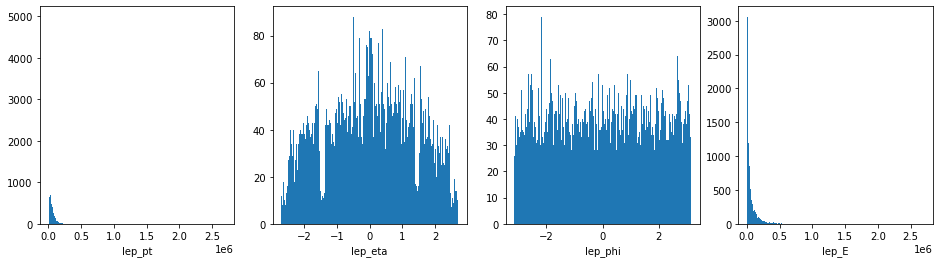

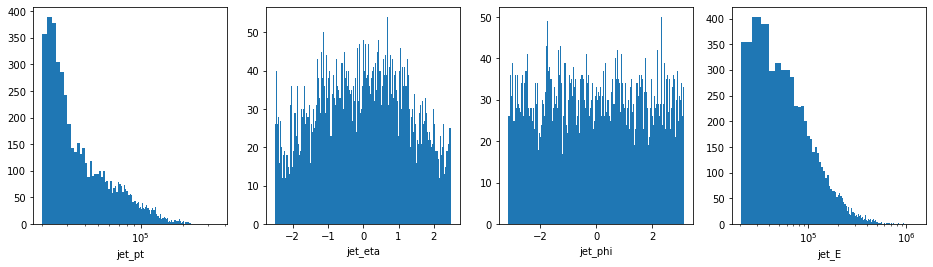

In [78]:
# Visualize the data

n_bins = 200

fig = plt.figure(figsize=(4*len(lep_branches), 4))
for i, branch in enumerate(lep_branches):
    plt.subplot(1, len(lep_branches), i+1)
    plt.hist(lep_data[branch], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(branch)
    #plt.yscale('log')

fig = plt.figure(figsize=(4*len(jet_branches), 4))
for i, branch in enumerate(jet_branches):
    plt.subplot(1, len(jet_branches), i+1)
    plt.hist(jet_data[branch], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(branch)
    #plt.yscale('log')
    if i in [0, 3]:
        plt.xscale('log')

n_jets = len(jet_data)
n_lep = len(lep_data)

print('Number of lepton four-momenta:', len(lep_data))
print('Number of jet four-momenta:', len(jet_data))

In [79]:
data_path = r'./pickles'
#data_filename = r'mc_110903.ZPrime1000.root'
jet_filename = data_filename.strip('.root') + r'-jet.pkl'
lep_filename = data_filename.strip('.root') + r'-lep.pkl'

jet_data.to_pickle(os.sep.join([data_path, jet_filename]))
lep_data.to_pickle(os.sep.join([data_path, lep_filename]))

In [80]:
# Create an information file for the current .pkl

pickle_info_filename = 'pickles.info'
pickle_info = {'dataset_name' : dataset_name,
                'jet_filename' : jet_filename,
               'n_jets' : n_jets,
               'lep_filename' : lep_filename,
               'n_lep' : n_lep}
file = open(os.sep.join([data_path, pickle_info_filename]), 'a')
file.write('\n%')
for key in pickle_info.keys():
    file.write('\n')
    file.write(key)
    file.write('\n')
    file.write(str(pickle_info[key]))
file.close()

# Show pickle file contents

In [4]:
t = time.perf_counter()
pickled_data = pd.read_pickle(r'F:\Master\Data\pickles\data_D.2lep-jet.pkl')
print('Read time:', time.perf_counter() - t, 'seconds.')

Read time: 1.427852999999999 seconds.


In [5]:
pickled_data

jet_pt   jet_eta   jet_phi          jet_E   jet_jvt  \
entry   subentry                                                              
4       0         63805.328125  1.203108  3.099957  116042.437500  0.991898   
        1         21522.468750  2.361825 -1.167996  115300.562500  0.981763   
5       0         40107.675781 -1.411193 -1.858008   87624.882812  0.998283   
        1         33406.589844 -0.709983  0.043586   42859.734375  0.992187   
        2         23021.287109 -1.416613 -0.340813   50585.496094  0.880674   
...                        ...       ...       ...            ...       ...   
5490382 1         20144.808594  0.478414  1.471330   22780.019531  0.987831   
5490386 0         86004.914062 -1.423896 -2.513129  189496.953125  0.980716   
5490389 0         44000.156250  1.202855 -1.393303   80058.570312  0.994756   
5490390 0         54359.460938 -0.834115 -2.539023   74981.937500  0.994851   
5490394 0         32128.435547  2.480807 -2.431600  193448.875000  0.552322   

                  jet_MV2c10  
entry   subentry              
4       0          -0.539400  
        1          -0.912779  
5       0          -0.785531  
        1          -0.879459  
        2          -0.813661  
...                      ...  
5490382 1          -0.807435  
5490386 0          -0.829829  
5490389 0          -0.900436  
5490390 0           0.999946  
5490394 0          -0.488721  

[3898273 rows x 6 columns]